In [1]:
import torch
from torch import nn
from torchinfo import summary
import pandas as pd
from pathlib import Path
import numpy as np
torch.__version__
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from funciones_redes import *

In [2]:
seed = 77

np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
data = np.load('Datos/Transformados/montecarlo_data.npz')
features = data['features']
target = data['target']
target = target.reshape(-1, 1)
print(target.shape)

(100000, 1)


In [4]:
n_sims, n_pasos, n_features_count = features.shape
features_reshaped = features.reshape(-1, n_features_count)
scaler = StandardScaler()
features_scaled_reshaped = scaler.fit_transform(features_reshaped)
features_scaled = features_scaled_reshaped.reshape(n_sims, n_pasos, n_features_count)

import joblib
joblib.dump(scaler, 'scaler_entrenado.gz') 
print("Scaler guardado en 'scaler_entrenado.gz'")


X_train, X_temp, Y_train, Y_temp = train_test_split(
    features_scaled, target, test_size=0.40, random_state=42
)

X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.50, random_state=42 # 0.50 * 0.40 = 0.20
)

print(f"Total de muestras: {len(features_scaled)}")
print(f"Muestras de Entrenamiento (X_train): {len(X_train)} (60%)")
print(f"Muestras de Validación (X_val):     {len(X_val)} (20%)")
print(f"Muestras de Prueba (X_test):      {len(X_test)} (20%)")

# Paso 3. Crear los DataLoaders
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)

val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(Y_val, dtype=torch.float32))
val_dataloader = DataLoader(val_data, batch_size=128, shuffle=False)

test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32))
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=False)

Scaler guardado en 'scaler_entrenado.gz'
Total de muestras: 100000
Muestras de Entrenamiento (X_train): 60000 (60%)
Muestras de Validación (X_val):     20000 (20%)
Muestras de Prueba (X_test):      20000 (20%)


In [5]:
param_grid = {
    'model_type': ['LSTM', 'GRU'],
    'lr': [0.001, 0.0005],
    'hidden_dim': [32, 64]
}

results_tracker = []
run_counter = 0

from itertools import product
keys, values = zip(*param_grid.items())

for v in product(*values):
    params = dict(zip(keys, v))
    run_counter += 1
    model_save_path = f"modelos/model_run_{run_counter}.pt"
    
    print(f"Ejecución {run_counter}: {params}")
    torch.manual_seed(seed)
    
    if params['model_type'] == 'LSTM':
        model = RNNModel(input_dim=3, hidden_dim=params['hidden_dim'], output_dim=1, n_layers=1)
    elif params['model_type'] == 'GRU':
        model = GRUModel(input_dim=3, hidden_dim=params['hidden_dim'], output_dim=1, n_layers=1)

    # Entrenamiento
    early_stopper = EarlyStopper(patience=5, min_delta=0, save_path=model_save_path)
    history = train_model(
        model=model, train_dataloader=train_dataloader, val_dataloader=val_dataloader,
        lr=params['lr'], epochs=50, early_stopping=early_stopper
    )
    
    model.load_state_dict(torch.load(model_save_path))
    
    # Evaluar
    test_mse, test_rmse, test_mae = evaluate_on_test_set(model, test_dataloader)
    print(f"Resultados en Test: RMSE={test_rmse:.6f}, MAE={test_mae:.6f}")

    # Guardar resultados
    run_results = params.copy()
    run_results['val_loss'] = early_stopper.min_validation_loss
    run_results['test_rmse'] = test_rmse
    run_results['test_mae'] = test_mae
    run_results['epochs_run'] = len(history['epoch'])
    run_results['model_path'] = model_save_path
    results_tracker.append(run_results)

Ejecución 1: {'model_type': 'LSTM', 'lr': 0.001, 'hidden_dim': 32}
Epoch 1 LOSS train 0.00028121119452262063 valid 3.3377722666045883e-05
Epoch 2 LOSS train 1.8160697419565016e-05 valid 1.0614340904521668e-05
Epoch 3 LOSS train 1.1773178047224065e-05 valid 1.1576824529765872e-05
Epoch 4 LOSS train 7.840647467431457e-06 valid 7.097913570396486e-06
Epoch 5 LOSS train 6.815151273137114e-06 valid 1.2899515607568902e-05
Epoch 6 LOSS train 6.5552150875494895e-06 valid 2.872486702926835e-06
Epoch 7 LOSS train 5.350984293424214e-06 valid 1.4785775475684204e-05
Epoch 8 LOSS train 8.748695855138066e-06 valid 7.043368909046422e-06
Epoch 9 LOSS train 5.802261254666519e-06 valid 5.811531215726972e-06
Epoch 10 LOSS train 3.857421925082842e-06 valid 2.767515536834253e-06
Epoch 11 LOSS train 5.1297000796087865e-06 valid 2.632157341368213e-06
Epoch 12 LOSS train 4.150425843363336e-06 valid 2.5927028241312654e-06
Epoch 13 LOSS train 4.109708576349173e-06 valid 1.6357951090583356e-06
Epoch 14 LOSS train 

In [7]:
# Análisis de Resultados 
results_df = pd.DataFrame(results_tracker)
results_df = results_df.sort_values(by='val_loss', ascending=True)

print("--- TABLA COMPARATIVA DE MODELOS (ordenada por Val Loss) ---")

# Formatear
results_df['model_params'] = results_df.apply(
    lambda row: f"{row['model_type']}(hidden={row['hidden_dim']})", axis=1
)
results_df['train_params'] = results_df.apply(
    lambda row: f"lr={row['lr']}", axis=1
)

# Seleccionar y renombrar
display_df = results_df[[
    'model_params',
    'train_params',
    'test_mae', 
    'test_rmse',
    'val_loss',
    'epochs_run'
]].rename(columns={
    'model_params': 'Modelo',
    'train_params': 'Hiperparámetros',
    'test_mae': 'MAE (Test)',
    'test_rmse': 'RMSE (Test)',
    'val_loss': 'Val Loss (MSE)',
    'epochs_run': 'Épocas'
})

print(display_df.to_markdown(index=False, floatfmt=".8f"))

#  Seleccionar el MEJOR modelo (basado en val_loss) 
best_run = results_df.iloc[0]
best_model_path = best_run['model_path']
best_params = best_run.to_dict()

print(f"\nMEJOR MODELO (basado en Val Loss): {best_model_path}")
print(f"Hiperparámetros: {best_params}")

--- TABLA COMPARATIVA DE MODELOS (ordenada por Val Loss) ---
| Modelo          | Hiperparámetros   |   MAE (Test) |   RMSE (Test) |   Val Loss (MSE) |   Épocas |
|:----------------|:------------------|-------------:|--------------:|-----------------:|---------:|
| GRU(hidden=64)  | lr=0.0005         |   0.00024170 |    0.00097587 |       0.00000082 |       28 |
| LSTM(hidden=64) | lr=0.001          |   0.00030249 |    0.00115951 |       0.00000119 |       19 |
| GRU(hidden=32)  | lr=0.001          |   0.00030448 |    0.00130553 |       0.00000129 |       24 |
| LSTM(hidden=32) | lr=0.0005         |   0.00029789 |    0.00122748 |       0.00000139 |       25 |
| LSTM(hidden=32) | lr=0.001          |   0.00034243 |    0.00134068 |       0.00000164 |       18 |
| GRU(hidden=64)  | lr=0.001          |   0.00041687 |    0.00150961 |       0.00000189 |       17 |
| GRU(hidden=32)  | lr=0.0005         |   0.00036622 |    0.00153625 |       0.00000190 |       23 |
| LSTM(hidden=64) | lr=0.0005 

In [8]:
torch.manual_seed(seed)

if best_params['model_type'] == 'LSTM':
    model = RNNModel(input_dim=3, hidden_dim=int(best_params['hidden_dim']), output_dim=1, n_layers=1)
elif best_params['model_type'] == 'GRU':
    model = GRUModel(input_dim=3, hidden_dim=int(best_params['hidden_dim']), output_dim=1, n_layers=1)

early_stopper_best = EarlyStopper(patience=5, min_delta=0)

history_best = train_model(
    model=model, train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    lr=best_params['lr'], epochs=50, early_stopping=early_stopper_best
)

Epoch 1 LOSS train 0.0003413660983215474 valid 5.13753478138824e-05
Epoch 2 LOSS train 3.2163503384557166e-05 valid 1.6562486740440364e-05
Epoch 3 LOSS train 1.6624755955611665e-05 valid 1.953566406155005e-05
Epoch 4 LOSS train 1.1349328022333794e-05 valid 7.771367226814618e-06
Epoch 5 LOSS train 9.265330503330916e-06 valid 5.100881818725611e-06
Epoch 6 LOSS train 6.186476209768443e-06 valid 6.979760092872311e-06
Epoch 7 LOSS train 8.398775427728348e-06 valid 5.4404167807661e-06
Epoch 8 LOSS train 5.4536289383880405e-06 valid 1.4831308138673193e-05
Epoch 9 LOSS train 5.9259656495366164e-06 valid 4.769959847544669e-06
Epoch 10 LOSS train 5.451109127776969e-06 valid 4.071817486601503e-06
Epoch 11 LOSS train 5.148733873253756e-06 valid 4.947633551728359e-06
Epoch 12 LOSS train 6.393442460951822e-06 valid 2.6064749215947814e-06
Epoch 13 LOSS train 3.855694706453505e-06 valid 6.784498727938626e-06
Epoch 14 LOSS train 5.335931626602057e-06 valid 2.608123539830558e-05
Epoch 15 LOSS train 4.35

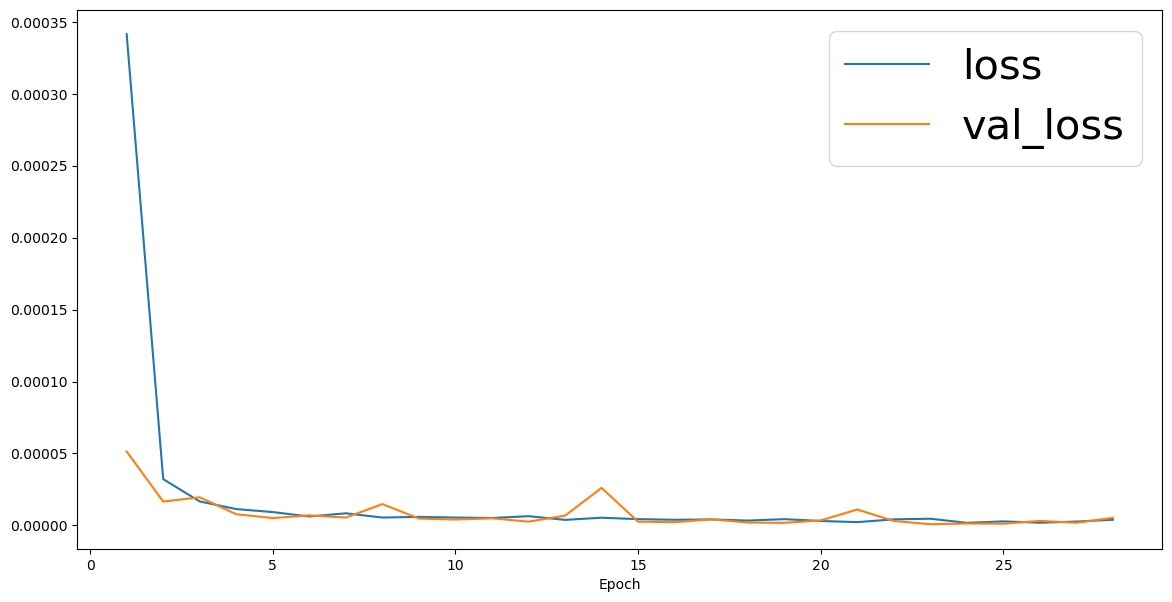

In [9]:
plot_history(history_best, plot_list= ["loss","val_loss"])

Cargando el MEJOR modelo (modelos/model_run_8.pt) para evaluación final


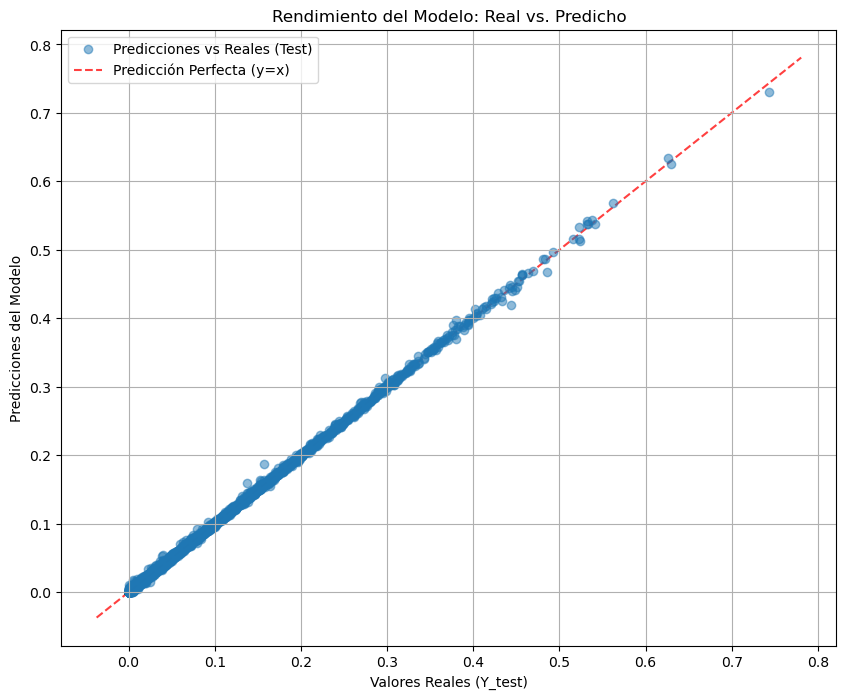


--- RESULTADOS FINALES DEL MEJOR MODELO EN TEST SET ---
Tiempo:  0.67786980
MSE:  0.00000095
RMSE: 0.00097587
MAE:  0.00024170


In [10]:
#  EVALUACIÓN FINAL DEL MEJOR MODELO 
import time 

print(f"Cargando el MEJOR modelo ({best_model_path}) para evaluación final")

if best_params['model_type'] == 'LSTM':
    model = RNNModel(input_dim=3, hidden_dim=best_params['hidden_dim'], output_dim=1) 
elif best_params['model_type'] == 'GRU':
    model = GRUModel(input_dim=3, hidden_dim=best_params['hidden_dim'], output_dim=1)

model.load_state_dict(torch.load(best_model_path))
model.eval()

start_time = time.perf_counter()

predicciones = []
reales = []
with torch.no_grad():
    for data in test_dataloader:
        inputs, targets = data[0], data[1]
        outputs = model(inputs)
        predicciones.append(outputs.numpy())
        reales.append(targets.numpy())
end_time = time.perf_counter()

tiempo = end_time - start_time
predicciones_np = np.concatenate(predicciones)
reales_np = np.concatenate(reales)

plt.figure(figsize=(10, 8))
plt.scatter(reales_np, predicciones_np, alpha=0.5, label='Predicciones vs Reales (Test)') 
lims = [
    np.min([plt.gca().get_xlim(), plt.gca().get_ylim()]),
    np.max([plt.gca().get_xlim(), plt.gca().get_ylim()]),
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Predicción Perfecta (y=x)')
plt.xlabel('Valores Reales (Y_test)')
plt.ylabel('Predicciones del Modelo')
plt.title('Rendimiento del Modelo: Real vs. Predicho')
plt.legend()
plt.grid(True)
plt.savefig('graficos/rendimiento_modelo.png')
plt.show()

# Métricas finales (usando la función evaluate_on_test_set)
final_test_mse, final_test_rmse, final_test_mae = evaluate_on_test_set(model, test_dataloader) 
print("\n--- RESULTADOS FINALES DEL MEJOR MODELO EN TEST SET ---")
print(f"Tiempo:  {tiempo:.8f}")
print(f"MSE:  {final_test_mse:.8f}")
print(f"RMSE: {final_test_rmse:.8f}")
print(f"MAE:  {final_test_mae:.8f}")

In [11]:
# Resumen PAYOFF
min_pred = np.min(predicciones_np)
max_pred = np.max(predicciones_np)
mean_pred = np.mean(predicciones_np)

print(f"  - Valor Mínimo: {min_pred}")
print(f"  - Valor Máximo: {max_pred}")
print(f"  - Media: {mean_pred}")

  - Valor Mínimo: 0.0
  - Valor Máximo: 0.7301403880119324
  - Media: 0.014805941842496395


ANÁLISIS DE CONVERGENCIA

Tensor de Test (X_test_tensor_full) creado con shape: torch.Size([20000, 20, 3])
El Payoff real (Montecarlo) de referencia es: 0.01478056
Iniciando evaluación de convergencia de 1 a 20 pasos
  Con 1 pasos, la RNN predice un payoff de: 0.00000000
  Con 5 pasos, la RNN predice un payoff de: 0.00000000
  Con 10 pasos, la RNN predice un payoff de: 0.00000000
  Con 15 pasos, la RNN predice un payoff de: 0.00237367
  Con 20 pasos, la RNN predice un payoff de: 0.01480594

Gráfico 'comparativa_pasos_payoff.png' guardado exitosamente.


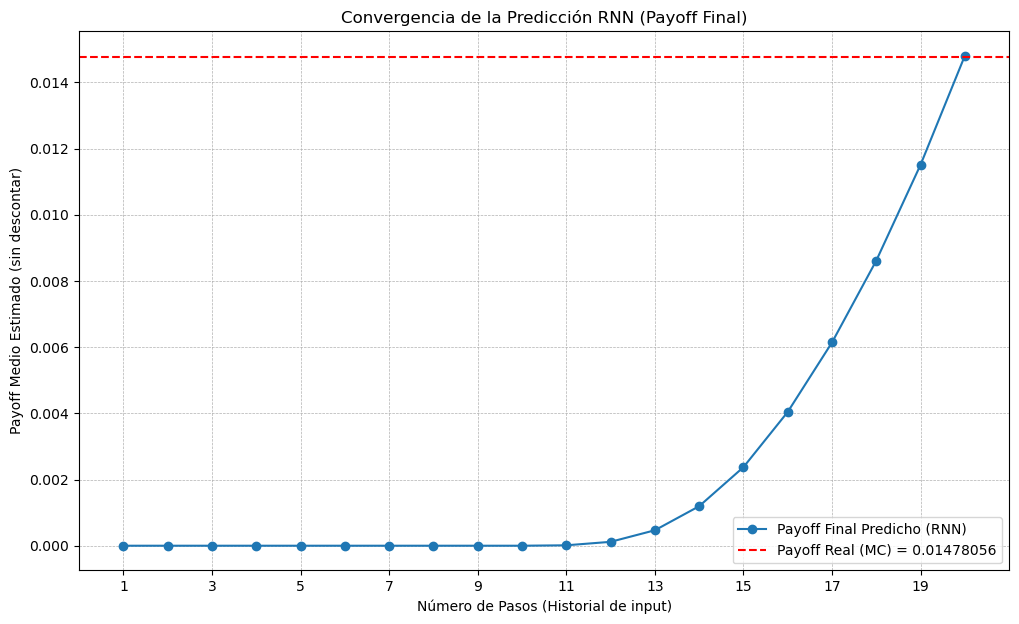

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt

model.eval()

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

print(f"Tensor de Test (X_test_tensor_full) creado con shape: {X_test_tensor.shape}")

# Calcular el Payoff Real 
payoff_real_mc_mean = np.mean(Y_test)
print(f"El Payoff real (Montecarlo) de referencia es: {payoff_real_mc_mean:.8f}")

lista_payoffs_rnn = []
num_pasos_max = X_test_tensor.shape[1]
pasos_a_evaluar = range(1, num_pasos_max + 1)

print(f"Iniciando evaluación de convergencia de 1 a {num_pasos_max} pasos")

for i in pasos_a_evaluar:
    
    X_test_padded = torch.zeros_like(X_test_tensor)
    X_test_padded[:, 0:i, :] = X_test_tensor[:, 0:i, :]

    # predicción
    with torch.no_grad():
        pred_tensor = model(X_test_padded)
        
    pred_np = pred_tensor.numpy()
    
    payoff_medio_predicho = np.mean(pred_np)
    lista_payoffs_rnn.append(payoff_medio_predicho)
    
    if (i % 5 == 0) or (i == 1) or (i == num_pasos_max):
        print(f"  Con {i} pasos, la RNN predice un payoff de: {payoff_medio_predicho:.8f}")

# Generar el Gráfico
plt.figure(figsize=(12, 7))
plt.plot(pasos_a_evaluar, lista_payoffs_rnn, marker='o', linestyle='-', label='Payoff Final Predicho (RNN)')
plt.axhline(y=payoff_real_mc_mean, color='red', linestyle='--', label=f'Payoff Real (MC) = {payoff_real_mc_mean:.8f}')

plt.xlabel('Número de Pasos (Historial de input)')
plt.ylabel('Payoff Medio Estimado (sin descontar)')
plt.title('Convergencia de la Predicción RNN (Payoff Final)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(pasos_a_evaluar[::2])
plt.xlim(0, num_pasos_max + 1)

# Guardar el gráfico
plt.savefig('graficos/comparativa_pasos_payoff.png')
print("\nGráfico 'comparativa_pasos_payoff.png' guardado exitosamente.")